# Training Log Interpreter

This notebook parses and visualizes training logs from the Int2Int model training.
It extracts model parameters, task information, and plots metrics over epochs.

In [26]:
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# to export, run 
# jupyter nbconvert interpret_train_log.ipynb --to webpdf --no-input

## Configuration

Specify the path to your training log file:

In [37]:
# train log file path
log_file_path = "../models/model_interCRT100_natural/mu/1/train.log"

## Parse Training Log

In [38]:
def parse_train_log(log_path):
    """
    Parse training log file to extract parameters and metrics.
    
    Returns:
        params: dict of training parameters
        metrics: list of dicts containing epoch metrics
    """
    params = {}
    metrics = []
    
    with open(log_path, 'r') as f:
        content = f.read()
    
    lines = content.split('\n')
    
    # Parse parameters (they appear at the beginning of the log)
    in_params_section = False
    for line in lines:
        # Detect start of parameters section
        if 'Initialized logger' in line:
            in_params_section = True
            continue
        
        # Detect end of parameters section
        if in_params_section and ('Running command' in line or 'Starting epoch' in line):
            in_params_section = False
        
        # Parse parameter lines
        if in_params_section:
            # Parameters are in format: "key: value"
            match = re.search(r'^\s+(\w+):\s+(.+)$', line)
            if match:
                key = match.group(1)
                value = match.group(2).strip()
                params[key] = value
        
        # Parse metric lines (contain __log__:)
        if '__log__:' in line:
            # Extract JSON part after __log__:
            json_str = line.split('__log__:', 1)[1]
            try:
                metric_data = json.loads(json_str)
                metrics.append(metric_data)
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse line: {line[:100]}...")
                print(f"Error: {e}")
    
    return params, metrics


# Parse the log file
params, metrics = parse_train_log(log_file_path)

print(f"Parsed {len(params)} parameters and {len(metrics)} epoch logs")

Parsed 102 parameters and 201 epoch logs


## Report Model Configuration and Training Parameters

In [39]:
def determine_task_type(params):
    """
    Determine if this is mu or musq task based on training/eval data paths.
    """
    train_data = params.get('train_data', '')
    eval_data = params.get('eval_data', '')
    
    # Check for musq in the data paths
    if 'musq' in train_data.lower() or 'musq' in eval_data.lower():
        return 'musq'
    elif 'mu' in train_data.lower() or 'mu' in eval_data.lower():
        return 'mu'
    else:
        return 'unknown'


def print_model_config(params):
    """
    Print key model configuration and training parameters.
    """
    task_type = determine_task_type(params)
    
    print("=" * 80)
    print("MODEL CONFIGURATION AND TRAINING PARAMETERS")
    print("=" * 80)
    
    print("\n - EXPERIMENT INFO")
    print(f"  Experiment Name: {params.get('exp_name', 'N/A')}")
    print(f"  Experiment ID: {params.get('exp_id', 'N/A')}")
    print(f"  Task Type: {task_type.upper()}")
    print(f"  Operation: {params.get('operation', 'N/A')}")
    
    print("\n - DATA")
    print(f"  Training Data: {params.get('train_data', 'N/A')}")
    print(f"  Eval Data: {params.get('eval_data', 'N/A')}")
    print(f"  Data Types: {params.get('data_types', 'N/A')}")
    print(f"  Base: {params.get('base', 'N/A')}")
    print(f"  Modulus: {params.get('modulus', 'N/A')}")
    
    print("\n - MODEL ARCHITECTURE")
    print(f"  Architecture: {params.get('architecture', 'N/A')}")
    print(f"  Encoder Layers: {params.get('n_enc_layers', 'N/A')}")
    print(f"  Decoder Layers: {params.get('n_dec_layers', 'N/A')}")
    print(f"  Encoder Embedding Dim: {params.get('enc_emb_dim', 'N/A')}")
    print(f"  Decoder Embedding Dim: {params.get('dec_emb_dim', 'N/A')}")
    print(f"  Encoder Heads: {params.get('n_enc_heads', 'N/A')}")
    print(f"  Decoder Heads: {params.get('n_dec_heads', 'N/A')}")
    print(f"  Dropout: {params.get('dropout', 'N/A')}")
    print(f"  Attention Dropout: {params.get('attention_dropout', 'N/A')}")
    
    print("\n - TRAINING PARAMETERS")
    print(f"  Optimizer: {params.get('optimizer', 'N/A')}")
    print(f"  Batch Size: {params.get('batch_size', 'N/A')}")
    print(f"  Eval Batch Size: {params.get('batch_size_eval', 'N/A')}")
    print(f"  Epoch Size: {params.get('epoch_size', 'N/A')}")
    print(f"  Max Epochs: {params.get('max_epoch', 'N/A')}")
    print(f"  Eval Size: {params.get('eval_size', 'N/A')}")
    print(f"  Gradient Clipping: {params.get('clip_grad_norm', 'N/A')}")
    print(f"  Max Length: {params.get('max_len', 'N/A')}")
    print(f"  Max Output Length: {params.get('max_output_len', 'N/A')}")
    
    print("\n - OTHER SETTINGS")
    print(f"  FP16: {params.get('fp16', 'N/A')}")
    print(f"  CPU Mode: {params.get('cpu', 'N/A')}")
    print(f"  Multi-GPU: {params.get('multi_gpu', 'N/A')}")
    print(f"  Num Workers: {params.get('num_workers', 'N/A')}")
    
    print("\n" + "=" * 80)
    
    return task_type


task_type = print_model_config(params)

MODEL CONFIGURATION AND TRAINING PARAMETERS

 - EXPERIMENT INFO
  Experiment Name: mu
  Experiment ID: 1
  Task Type: MU
  Operation: data

 - DATA
  Training Data: /mnt/c/Users/ziwen/clair/mobius_case_study/input/input_dir_interCRT100_natural/mu_interCRT100_natural.txt.train
  Eval Data: /mnt/c/Users/ziwen/clair/mobius_case_study/input/input_dir_interCRT100_natural/mu_interCRT100_natural.txt.test
  Data Types: int[200]:range(-1,2)
  Base: 1000
  Modulus: 67

 - MODEL ARCHITECTURE
  Architecture: encoder_decoder
  Encoder Layers: 4
  Decoder Layers: 4
  Encoder Embedding Dim: 256
  Decoder Embedding Dim: 256
  Encoder Heads: 8
  Decoder Heads: 8
  Dropout: 0
  Attention Dropout: 0

 - TRAINING PARAMETERS
  Optimizer: adam_inverse_sqrt,lr=0.00025
  Batch Size: 32
  Eval Batch Size: 128
  Epoch Size: 50000
  Max Epochs: 201
  Eval Size: 10000
  Gradient Clipping: 5
  Max Length: 512
  Max Output Length: 512

 - OTHER SETTINGS
  FP16: False
  CPU Mode: False
  Multi-GPU: False
  Num Worke

## Convert Metrics to DataFrame

In [40]:
# Convert metrics to DataFrame for easier analysis
df_metrics = pd.DataFrame(metrics)

# Display first few rows
print(f"Total epochs recorded: {len(df_metrics)}")
print("\nFirst few epochs:")
df_metrics.head(10)

Total epochs recorded: 201

First few epochs:


,epoch,valid_arithmetic_xe_loss,valid_arithmetic_acc,valid_arithmetic_perfect,valid_arithmetic_correct,valid_arithmetic_acc_d1,valid_arithmetic_acc_d2,valid_arithmetic_acc_d3,valid_arithmetic_acc_0,valid_arithmetic_acc_1,valid_arithmetic_acc_100
0,0,1.007836,50.00,50.00,50.00,50.00,50.00,50.00,94.526477,0.000000,42.531395
1,1,0.993641,49.66,49.66,49.66,49.66,49.66,79.33,75.178208,66.086671,0.000000
2,2,0.960894,51.12,51.12,51.12,51.12,51.12,76.85,81.797352,62.344058,0.000000
3,3,0.968453,51.59,51.59,51.59,51.59,51.59,69.85,91.726069,51.083388,0.000000
4,4,0.951594,51.41,51.41,51.41,51.41,51.41,57.73,91.726069,21.766251,28.916061
5,5,0.948991,51.19,51.19,51.19,51.19,51.19,61.02,92.540733,23.900197,24.983477
6,6,0.952735,50.83,50.83,50.83,50.83,50.83,50.83,92.897149,0.000000,47.389293
7,7,0.960436,51.08,51.08,51.08,51.08,51.08,76.81,81.771894,62.245568,0.000000
8,8,0.949581,51.60,51.60,51.60,51.60,51.60,68.46,92.006110,48.424163,2.346332
9,9,0.952955,50.91,50.91,50.91,50.91,50.91,50.91,93.100815,0.000000,47.389293


## Plot 1: Cross-Entropy Loss

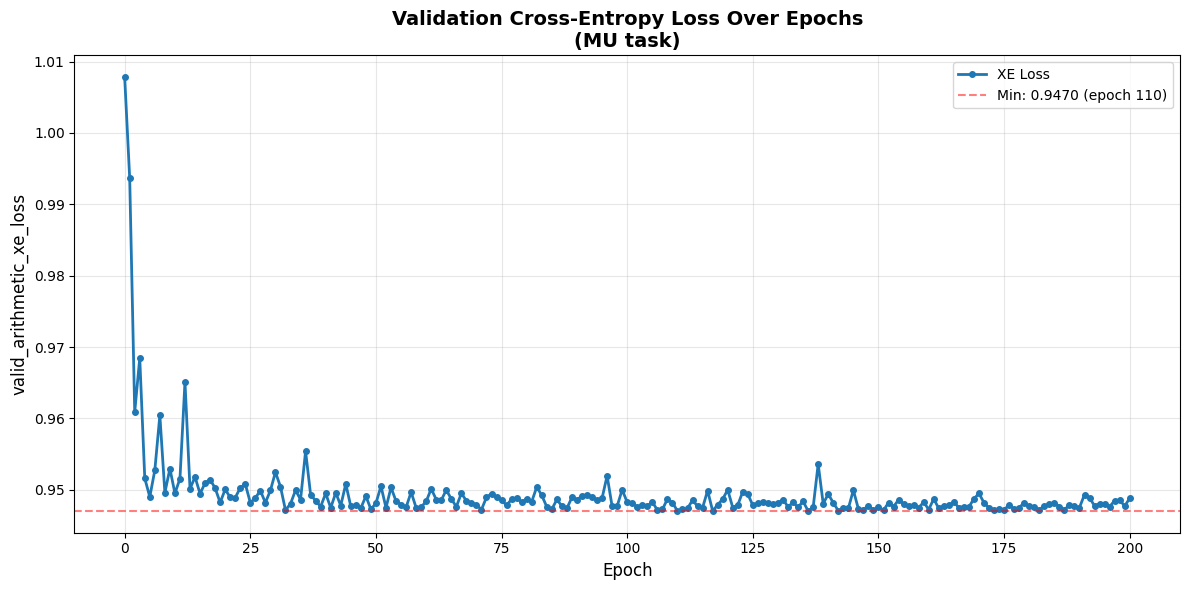

In [41]:
plt.figure(figsize=(12, 6))

if 'valid_arithmetic_xe_loss' in df_metrics.columns:
    plt.plot(df_metrics['epoch'], df_metrics['valid_arithmetic_xe_loss'], 
             marker='o', linewidth=2, markersize=4, label='XE Loss')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('valid_arithmetic_xe_loss', fontsize=12)
    plt.title(f'Validation Cross-Entropy Loss Over Epochs\n({task_type.upper()} task)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Add min value annotation
    min_loss = df_metrics['valid_arithmetic_xe_loss'].min()
    min_epoch = df_metrics.loc[df_metrics['valid_arithmetic_xe_loss'].idxmin(), 'epoch']
    plt.axhline(y=min_loss, color='r', linestyle='--', alpha=0.5, label=f'Min: {min_loss:.4f} (epoch {min_epoch})')
    plt.legend(fontsize=10)
else:
    plt.text(0.5, 0.5, 'valid_arithmetic_xe_loss not found in metrics', 
             ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

## Plot 2: Accuracy Metrics (acc, perfect, correct)

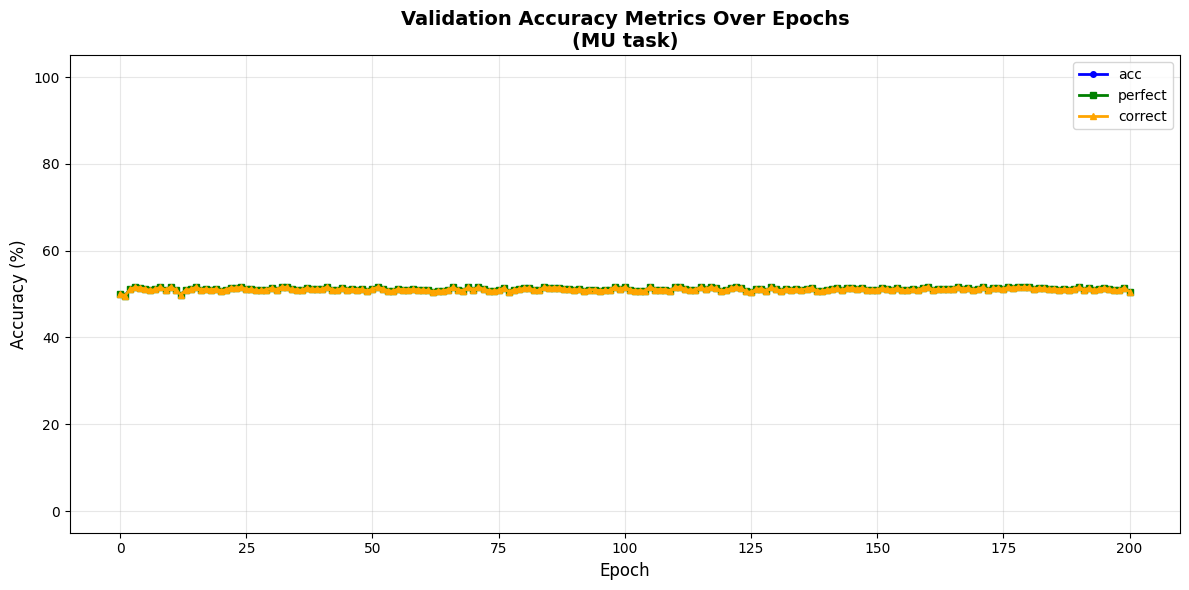

In [42]:
plt.figure(figsize=(12, 6))

acc_metrics = ['valid_arithmetic_acc', 'valid_arithmetic_perfect', 'valid_arithmetic_correct']
colors = ['blue', 'green', 'orange']
markers = ['o', 's', '^']

for metric, color, marker in zip(acc_metrics, colors, markers):
    if metric in df_metrics.columns:
        plt.plot(df_metrics['epoch'], df_metrics[metric], 
                marker=marker, linewidth=2, markersize=4, 
                color=color, label=metric.replace('valid_arithmetic_', ''))

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Validation Accuracy Metrics Over Epochs\n({task_type.upper()} task)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.ylim([-5, 105])  # Set y-axis range for percentages

plt.tight_layout()
plt.show()

## Plot 3: Class-specific Accuracies (acc_0, acc_1, acc_100)

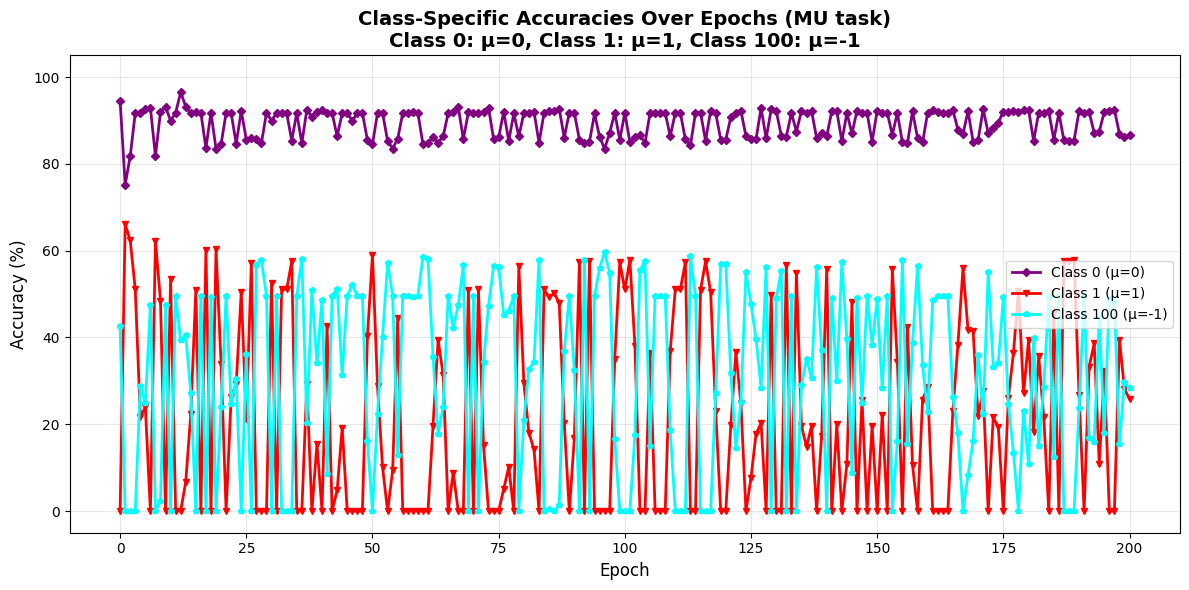

In [43]:
plt.figure(figsize=(12, 6))

class_metrics = ['valid_arithmetic_acc_0', 'valid_arithmetic_acc_1', 'valid_arithmetic_acc_100']
colors = ['purple', 'red', 'cyan']
markers = ['D', 'v', 'p']
labels = ['Class 0 (μ=0)', 'Class 1 (μ=1)', 'Class 100 (μ=-1)']

has_any_metric = False
for metric, color, marker, label in zip(class_metrics, colors, markers, labels):
    if metric in df_metrics.columns:
        has_any_metric = True
        plt.plot(df_metrics['epoch'], df_metrics[metric], 
                marker=marker, linewidth=2, markersize=4, 
                color=color, label=label)

if has_any_metric:
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    
    if task_type == 'mu':
        plt.title(f'Class-Specific Accuracies Over Epochs (MU task)\nClass 0: μ=0, Class 1: μ=1, Class 100: μ=-1', 
                 fontsize=14, fontweight='bold')
    else:
        plt.title(f'Class-Specific Accuracies Over Epochs ({task_type.upper()} task)', 
                 fontsize=14, fontweight='bold')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.ylim([-5, 105])  # Set y-axis range for percentages
else:
    plt.text(0.5, 0.5, 'No class-specific accuracy metrics found', 
             ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

## Best Metrics Report

In [44]:
def report_best_metrics(df_metrics):
    """
    Report the best (minimum for loss, maximum for accuracies) metrics across all epochs.
    """
    print("=" * 80)
    print("BEST METRICS ACROSS ALL EPOCHS")
    print("=" * 80)
    
    # Cross-Entropy Loss (lower is better)
    if 'valid_arithmetic_xe_loss' in df_metrics.columns:
        min_loss = df_metrics['valid_arithmetic_xe_loss'].min()
        min_loss_epoch = df_metrics.loc[df_metrics['valid_arithmetic_xe_loss'].idxmin(), 'epoch']
        print("\n📉 CROSS-ENTROPY LOSS")
        print(f"  Best Loss: {min_loss:.6f}")
        print(f"  Achieved at Epoch: {min_loss_epoch}")
    
    # Accuracy metrics (higher is better)
    print("\n📈 ACCURACY METRICS")
    acc_metrics = ['valid_arithmetic_acc', 'valid_arithmetic_perfect', 'valid_arithmetic_correct']
    
    for metric in acc_metrics:
        if metric in df_metrics.columns:
            max_acc = df_metrics[metric].max()
            max_acc_epoch = df_metrics.loc[df_metrics[metric].idxmax(), 'epoch']
            metric_name = metric.replace('valid_arithmetic_', '').upper()
            print(f"\n  {metric_name}:")
            print(f"    Best: {max_acc:.2f}%")
            print(f"    Achieved at Epoch: {max_acc_epoch}")
    
    # Class-specific accuracies
    class_metrics = ['valid_arithmetic_acc_0', 'valid_arithmetic_acc_1', 'valid_arithmetic_acc_100']
    class_labels = ['Class 0 (μ=0)', 'Class 1 (μ=1)', 'Class 100 (μ=-1)']
    
    has_class_metrics = any(metric in df_metrics.columns for metric in class_metrics)
    
    if has_class_metrics:
        print("\n📊 CLASS-SPECIFIC ACCURACIES")
        for metric, label in zip(class_metrics, class_labels):
            if metric in df_metrics.columns:
                max_acc = df_metrics[metric].max()
                max_acc_epoch = df_metrics.loc[df_metrics[metric].idxmax(), 'epoch']
                print(f"\n  {label}:")
                print(f"    Best: {max_acc:.2f}%")
                print(f"    Achieved at Epoch: {max_acc_epoch}")
    
    # Summary statistics
    print("\n" + "=" * 80)

    # Latest epoch metrics
    if len(df_metrics) > 0:
        print("\n📍 LATEST EPOCH METRICS:")
        last_row = df_metrics.iloc[-1]
        print(f"  Epoch: {last_row['epoch']}")
        if 'valid_arithmetic_xe_loss' in last_row:
            print(f"  XE Loss: {last_row['valid_arithmetic_xe_loss']:.6f}")
        if 'valid_arithmetic_acc' in last_row:
            print(f"  Accuracy: {last_row['valid_arithmetic_acc']:.2f}%")
        if 'valid_arithmetic_perfect' in last_row:
            print(f"  Perfect: {last_row['valid_arithmetic_perfect']:.2f}%")
    
    print("\n" + "=" * 80)


report_best_metrics(df_metrics)

BEST METRICS ACROSS ALL EPOCHS

📉 CROSS-ENTROPY LOSS
  Best Loss: 0.947016
  Achieved at Epoch: 110

📈 ACCURACY METRICS

  ACC:
    Best: 51.70%
    Achieved at Epoch: 98

  PERFECT:
    Best: 51.70%
    Achieved at Epoch: 98

  CORRECT:
    Best: 51.70%
    Achieved at Epoch: 98

📊 CLASS-SPECIFIC ACCURACIES

  Class 0 (μ=0):
    Best: 96.51%
    Achieved at Epoch: 12

  Class 1 (μ=1):
    Best: 66.09%
    Achieved at Epoch: 1

  Class 100 (μ=-1):
    Best: 59.72%
    Achieved at Epoch: 96


📍 LATEST EPOCH METRICS:
  Epoch: 200.0
  XE Loss: 0.948810
  Accuracy: 50.45%
  Perfect: 50.45%

